# Zero-Noise Extrapolation (ZNE) with Indirect-Control System
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Noisy XY time-evolution.
- Time-constraint: True

## (1) Import and setup

In [1]:
# ============================================================
#  Imports
# ============================================================

# --- Standard Libraries ---
import os
import sys
import json
import textwrap
import importlib
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Tuple, Union, Optional
from pprint import pprint

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate
from IPython.display import display

# --- Local Modules ---
# Dynamically add `src/` to sys.path (go up two levels)
notebook_dir = Path.cwd()
sys.path.append(str(notebook_dir.parents[2] / "src"))

from nbutils.compile_plot import compile_zne_subplots
from nbutils.zne_plot import plot_zne_result
from nbutils.summarize import summarize_zne_results
from nbutils.export_raw_data_wrapped import export_raw_data_wrapped

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

In [3]:
BASE_PATH = "data"

ZNE_MODELS = ["xy-ric2",
            "xy-ric3",
            "xy-ric4",
            "xy-ric5",
            "xy-ric6",
            "xy-ric7",
]

JSON_ENDS_WITH = {
    "vqe": "_vqe.json",
    "redundant": "_redundant.json",
    "zne": "_zne.json",
    "noiseoff": "_noise_off.json"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
]

pdf_reports: bool = True
detailed_reports: bool = True

timestamp: str = datetime.now().strftime("%Y%m%d-%H%M%S")
plot_dir: str = f"reports/{timestamp}/plots"
artifact_dir: str = f"reports/{timestamp}/artifacts"

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [4]:
# Storage
ALL_RAW_DATA = {
    model: {key: [] for key in JSON_ENDS_WITH}
    for model in ZNE_MODELS
}

# Load loop
for model in ZNE_MODELS:
    model_path = os.path.join(BASE_PATH, model)
    if not os.path.isdir(model_path):
        print(f"[WARNING] Skipping missing dir: {model_path}")
        continue
    
    for filename in os.listdir(model_path):
        if not filename.endswith(".json"):
            continue
        
        filepath = os.path.join(model_path, filename)
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[ERROR] {filepath}: {e}")
            continue
        
        filename_lower = filename.lower()
        for key, suffix in JSON_ENDS_WITH.items():
            if filename_lower.endswith(suffix):
                ALL_RAW_DATA[model][key].append(data)
                break

## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.

### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [5]:
EXACT_SOL: float = -8.566772233505624
EXTRAPOL_TARGET = 0.0  # Extrapolated noise level
print(f"Exact solution: {EXACT_SOL}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

### (C) Processing raw data

In [6]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}
    } for model in ZNE_MODELS
}

for model in ZNE_MODELS:
    
    ALL_PROCESSED_DATA[model]["vqe"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        )
    }
    # Based off the ZNE model, length of data points can be arbitrary
    n_levels = len(ALL_RAW_DATA[model]["redundant"][0]["output"]["data_points"])
    ALL_PROCESSED_DATA[model]["redundant"] = {
        "sorted_noise_levels": ALL_RAW_DATA[model]["zne"][0]["output"]["zne_values"]["others"]["sorted_noise"],
        "mean": [
            np.mean([
                ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][level][4]
                for i in range(len(ALL_RAW_DATA[model]["redundant"]))
            ])
            for level in range(n_levels)
        ],
        "std": [
            np.std([
                ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][level][4]
                for i in range(len(ALL_RAW_DATA[model]["redundant"]))
            ])
            for level in range(n_levels)
        ],
    }
   
    ALL_PROCESSED_DATA[model]["zne"] = {
        "mean": np.mean(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"] for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        ),
        "std": np.std(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"] for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        )
    }

    ALL_PROCESSED_DATA[model]["noiseoff"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        )
    }


In [7]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['sorted_noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))

Model    Category                    Mean        Std
-------  ---------------------  ---------  ---------
xy-ric2  vqe                    -6.4355    0.0714465
xy-ric2  redundant (noise=13)   -6.4355    0.0714465
xy-ric2  redundant (noise=47)   -3.29514   0.106993
xy-ric2  zne                    -7.63623   0.0732069
xy-ric2  noiseoff               -8.36934   0.15125
xy-ric3  vqe                    -6.4355    0.0714465
xy-ric3  redundant (noise=13)   -6.4355    0.0714465
xy-ric3  redundant (noise=47)   -3.29514   0.106993
xy-ric3  redundant (noise=81)   -1.72787   0.0936941
xy-ric3  zne                    -8.05195   0.0744181
xy-ric3  noiseoff               -8.36934   0.15125
xy-ric4  vqe                    -6.4355    0.0714465
xy-ric4  redundant (noise=13)   -6.4355    0.0714465
xy-ric4  redundant (noise=47)   -3.29514   0.106993
xy-ric4  redundant (noise=81)   -1.72787   0.0936941
xy-ric4  redundant (noise=115)  -0.920172  0.0709903
xy-ric4  zne                    -8.22268   0.0764238


## (4) Plot the results

Finally we can plot the results.

In [8]:
ALL_PLOTS = []

### #1 xy-ric2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251015-162653/plots' folder): xy_ric2.eps
{'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
 'redundant': {'sorted_noise_levels': [13, 47],
               'mean': [-6.435504654927096, -3.295143445760236],
               'std': [0.07144654504058068, 0.10699332304001417]},
 'zne': {'mean': -7.636230999608543, 'std': 0.07320688190321213},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


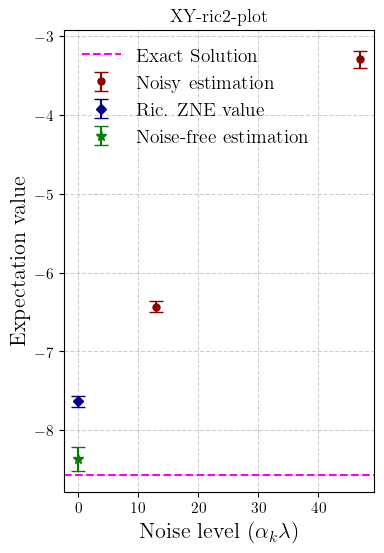

In [9]:
xy_ric2_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric2"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric2-plot",
    output_dir=f"reports/{timestamp}/plots",
    plot_file_name="xy_ric2.eps",
)

### #2 xy-ric3-plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251015-162653/plots' folder): xy_ric3.eps
{'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
 'redundant': {'sorted_noise_levels': [13, 47, 81],
               'mean': [-6.4355046549270964,
                        -3.295143445760236,
                        -1.7278654435467977],
               'std': [0.07144654504058066,
                       0.10699332304001397,
                       0.09369406425089988]},
 'zne': {'mean': -8.051954978608778, 'std': 0.07441805424896422},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


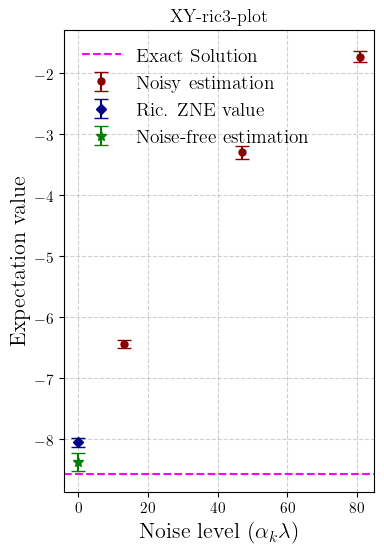

In [10]:
xy_ric3_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric3"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric3-plot",
    output_dir=f"reports/{timestamp}/plots",
    plot_file_name="xy_ric3.eps",
)

### #3 xy-ric4 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251015-162653/plots' folder): xy_ric4.eps
{'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
 'redundant': {'sorted_noise_levels': [13, 47, 81, 115],
               'mean': [-6.4355046549270964,
                        -3.295143445760236,
                        -1.7278654435467975,
                        -0.9201724866087432],
               'std': [0.07144654504058125,
                       0.10699332304001406,
                       0.09369406425089992,
                       0.07099031099868372]},
 'zne': {'mean': -8.222679067419104, 'std': 0.07642376885069371},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


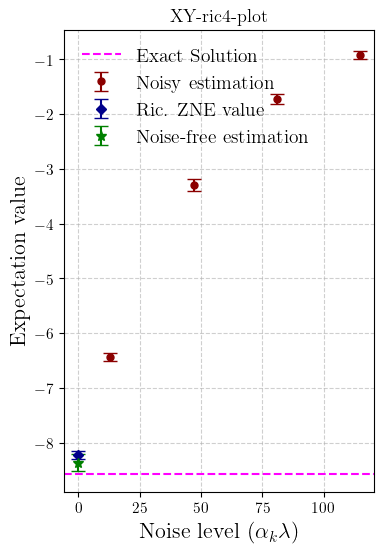

In [11]:
xy_ric4 = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric4"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric4-plot",
    output_dir=f"reports/{timestamp}/plots",
    plot_file_name="xy_ric4.eps",
)

### #4 xy-ric5 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251015-162653/plots' folder): xy_ric5.eps
{'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
 'redundant': {'sorted_noise_levels': [13, 47, 81, 115, 149],
               'mean': [-6.435504654927096,
                        -3.295143445760236,
                        -1.7278654435467975,
                        -0.9201724866087432,
                        -0.49236820988563734],
               'std': [0.0714465450405807,
                       0.10699332304001392,
                       0.09369406425089985,
                       0.07099031099868373,
                       0.05255661860984902]},
 'zne': {'mean': -8.29966094617771, 'std': 0.07818314745949498},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


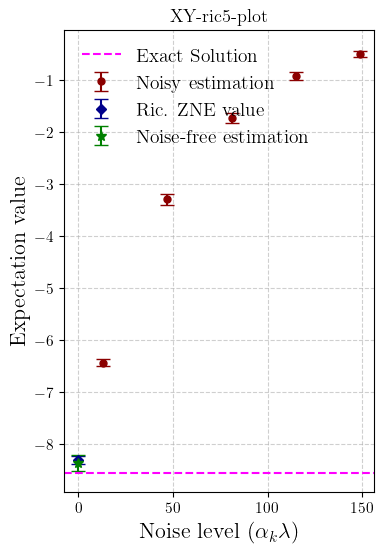

In [12]:
xy_ric5 = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric5"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric5-plot",
    output_dir=f"reports/{timestamp}/plots",
    plot_file_name="xy_ric5.eps",
)

### #5 xy-ric6 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251015-162653/plots' folder): xy_ric6.eps
{'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
 'redundant': {'sorted_noise_levels': [13, 47, 81, 115, 149, 183],
               'mean': [-6.435504654927096,
                        -3.295143445760236,
                        -1.7278654435467977,
                        -0.9201724866087432,
                        -0.49236820988563734,
                        -0.2609138044881395],
               'std': [0.07144654504058082,
                       0.10699332304001401,
                       0.09369406425089986,
                       0.07099031099868375,
                       0.052556618609849025,
                       0.039778004557132575]},
 'zne': {'mean': -8.33662348552183, 'std': 0.07942299397144209},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


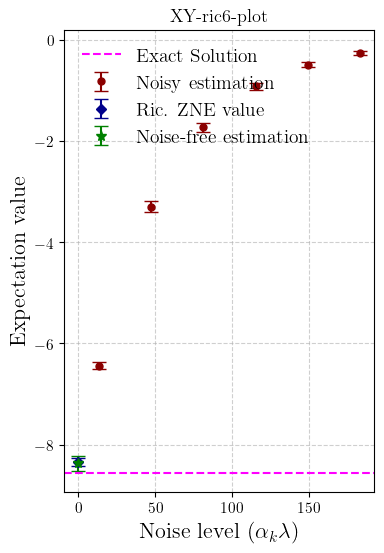

In [13]:
xy_ric6 = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric6"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric6-plot",
    output_dir=f"reports/{timestamp}/plots",
    plot_file_name="xy_ric6.eps",
)

### #6 xy-ric7 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251015-162653/plots' folder): xy_ric7.eps
{'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
 'redundant': {'sorted_noise_levels': [13, 47, 81, 115, 149, 183, 217],
               'mean': [-6.4355046549270964,
                        -3.295143445760236,
                        -1.7278654435467977,
                        -0.9201724866087432,
                        -0.49236820988563734,
                        -0.2609138044881395,
                        -0.1339562228054003],
               'std': [0.07144654504058078,
                       0.10699332304001401,
                       0.09369406425089985,
                       0.07099031099868368,
                       0.05255661860984903,
                       0.039778004557132575,
                       0.03105066847061813]},
 'zne': {'mean': -8.35520451635762, 'std': 0.0802210612172358},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


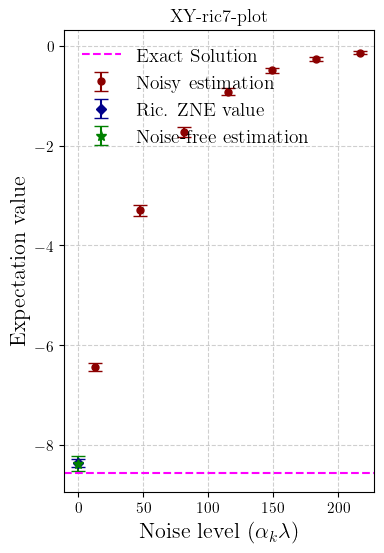

In [14]:
xy_ric7 = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric7"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric7-plot",
    output_dir=f"reports/{timestamp}/plots",
    plot_file_name="xy_ric7.eps",
)

### #7 Compiled ric-2 plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Compiled figure saved: reports/20251015-162653/plots/compiled_ric3.eps


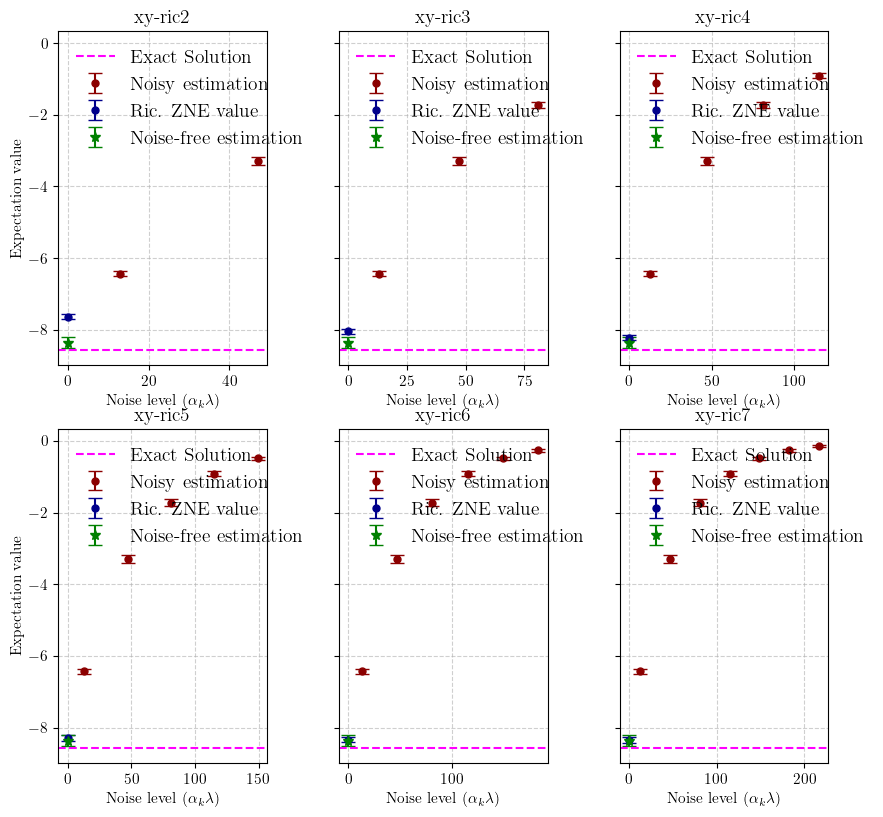

In [15]:
plot_titles = {
    "xy-ric2": "XY ansatz ric-2",
    "xy-ric3": "XY ansatz ric-3",
    "xy-ric4": "XY ansatz ric-4",
    "xy-ric5": "XY ansatz ric-5",
    "xy-ric6": "XY ansatz ric-6",
}

models_to_plot = ZNE_MODELS

xy_compiled_plt = compile_zne_subplots(
    data=ALL_PROCESSED_DATA,
    models=models_to_plot,
    plot_titles=plot_titles,
    plot_colors=plot_colors,
    exact_solution=EXACT_SOL,
    extrapol_target=EXTRAPOL_TARGET,
    ncols=3,
    figsize=(9, 9),
    output_dir=f"reports/{timestamp}/plots",
    filename_prefix="compiled_ric3"
)

## (7) Summary

=== Summary Table ===
   Description             Simulation          Mean ± Std
0      xy-ric2                    vqe  -6.43550 ± 0.07145
1      xy-ric2   redundant (noise=13)  -6.43550 ± 0.07145
2      xy-ric2   redundant (noise=47)  -3.29514 ± 0.10699
3      xy-ric2                    zne  -7.63623 ± 0.07321
4      xy-ric2               noiseoff  -8.36934 ± 0.15125
5                                                        
6      xy-ric3                    vqe  -6.43550 ± 0.07145
7      xy-ric3   redundant (noise=13)  -6.43550 ± 0.07145
8      xy-ric3   redundant (noise=47)  -3.29514 ± 0.10699
9      xy-ric3   redundant (noise=81)  -1.72787 ± 0.09369
10     xy-ric3                    zne  -8.05195 ± 0.07442
11     xy-ric3               noiseoff  -8.36934 ± 0.15125
12                                                       
13     xy-ric4                    vqe  -6.43550 ± 0.07145
14     xy-ric4   redundant (noise=13)  -6.43550 ± 0.07145
15     xy-ric4   redundant (noise=47)  -3.29514 ± 

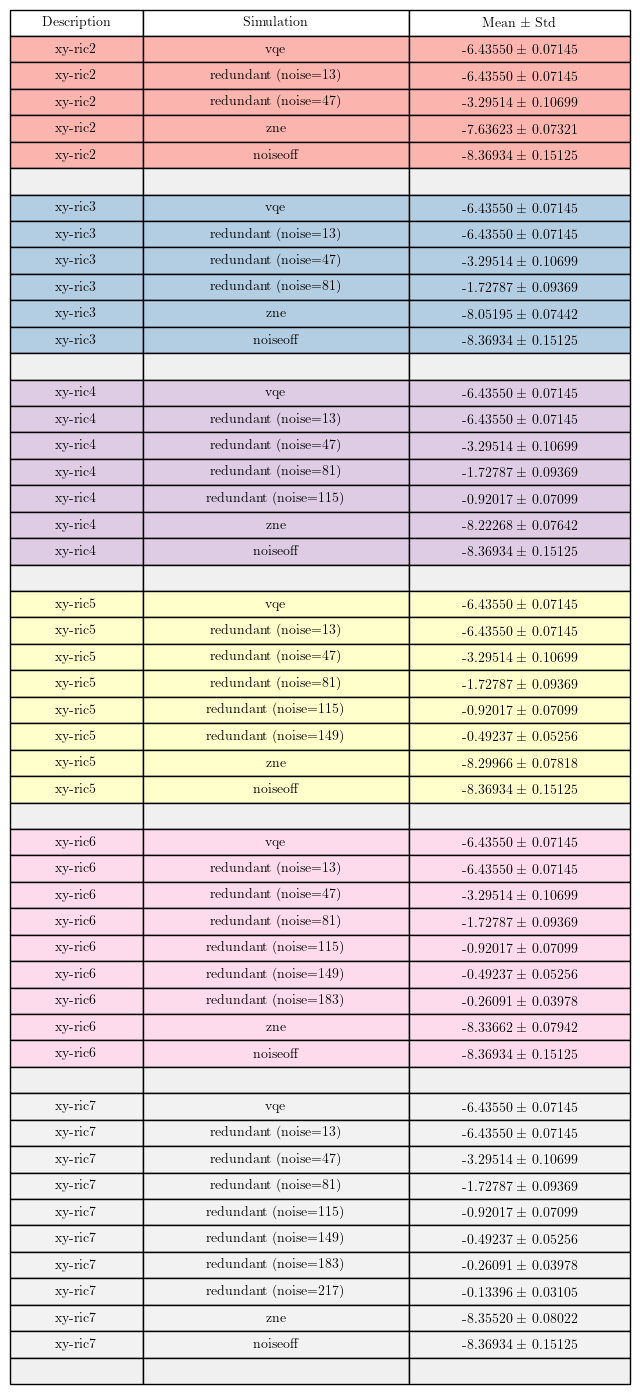

In [16]:
df_summary, fig = summarize_zne_results(
    ALL_PROCESSED_DATA=ALL_PROCESSED_DATA,
    selected_models=ZNE_MODELS,
    decimals=5,
    font_size=10,
    row_scale=1.3,
    output_dir=f"reports/{timestamp}/artifacts",
    save_name=f"zne_summary",
    save_formats=["eps","csv","latex"]
)

# Appendix
---

### PDF report

In [17]:
CONFIG_SUMMARY: dict = {
    "xy": ALL_RAW_DATA["xy-ric2"]["vqe"][0]["config"],
}
ALL_PLOTS = [
    xy_compiled_plt
]

In [18]:
HEIGHT = 0.2
WIDTH = 5
FILE_NAME = f"reports/{timestamp}/artifacts/zne_summary.pdf"

# Flatten deeply nested dicts
def flatten_config(config, prefix=""):
    flat = {}
    for k, v in config.items():
        full_key = f"{prefix}{k}"
        if isinstance(v, dict):
            flat.update(flatten_config(v, prefix=full_key + "."))
        else:
            flat[full_key] = v
    return flat

def render_model_config_page(model_name, config_dict):
    flat_config = flatten_config(config_dict)
    df = pd.DataFrame(list(flat_config.items()), columns=["Parameter", "Value"])

    # Estimate height dynamically
    row_height = HEIGHT  # inches per row
    max_width = WIDTH  # keep A4 landscape width if needed
    fig_height = max(2, min(len(df) * row_height + 1.5, 11))

    fig = plt.figure(figsize=(max_width, fig_height))
    ax = fig.add_axes([0, 0, 1, 1])  # Full area, no margin
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='left',
        loc='center',
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.3)  # Adjust row height for readability

    # Color header row
    for j in range(len(df.columns)):
        table[(0, j)].set_fontsize(9)
        table[(0, j)].set_facecolor("#dddddd")
        table[(0, j)].set_text_props(weight='bold')

    # Add title manually
    fig.text(0.5, 0.98, f"{model_name.upper()} VQE CONFIGURATION", ha='center', fontsize=12, weight='bold')

    return fig

if pdf_reports:
    with PdfPages(FILE_NAME) as pdf:
        # Save a main figure (if any)
        pdf.savefig(fig, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
        
        # Save multiple stored figures
        for stored_fig in ALL_PLOTS:
            pdf.savefig(stored_fig, bbox_inches='tight', pad_inches=0.05)
            plt.close(stored_fig)
        
        # Save config summary pages
        for model, config in CONFIG_SUMMARY.items():
            config_fig = render_model_config_page(model, config)
            pdf.savefig(config_fig, bbox_inches='tight', pad_inches=0.1)
            plt.close(config_fig)
        
        print("Result summary saved as PDF:", FILE_NAME)
else:
    print("PDF report generation skipped.")

Result summary saved as PDF: reports/20251015-162653/artifacts/zne_summary.pdf


In [19]:
if detailed_reports:
    export_raw_data_wrapped(ALL_RAW_DATA, pdf_filename=f"reports/{timestamp}/artifacts/big_json.pdf")
else:
    print("Detailed raw data PDF export skipped.")

✅ PDF saved as 'reports/20251015-162653/artifacts/big_json.pdf'


### Latex table